In [1]:
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import random
import arviz as az
import geopandas
import folium
import collections
import mapclassify
import math
import seaborn as sns

# Load country model

In [2]:
country_model = pd.read_pickle('../output/models/bayes_models/tfp_bayes_yfe_cre_for_drought_full/tfp_bayes_yfe_cre_for_drought_full_10k.pkl')
posterior = country_model["posterior"]
trace = country_model["trace"]
var_list = country_model["var_list"]
model_spec = country_model["model_spec"]
model_vars = ["global_country_rs_mean","global_country_rs_sd","country_rs_means","country_rs_sd","country_rs_coefs","model_variable_coefs","tfp_std","tfp_std_scale"]

# Convergence checks

/tmp/ipykernel_3077/2942097797.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


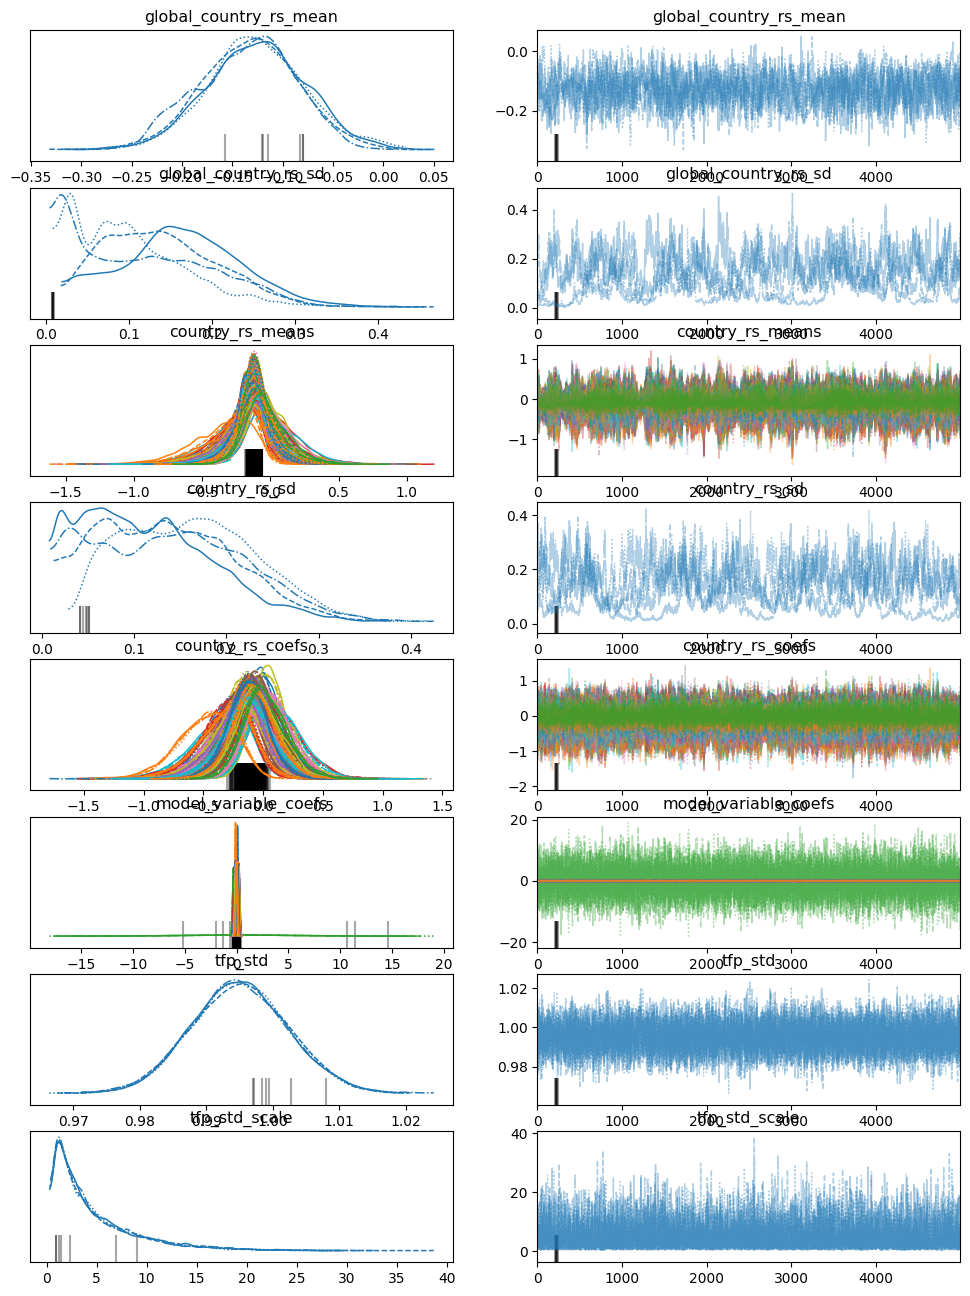

In [3]:
fig = az.plot_trace(trace, var_names=model_vars).ravel()[0].figure
fig.show()

In [4]:
az.summary(trace, var_names=model_vars)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_country_rs_mean,-0.130,0.049,-0.222,-0.040,0.002,0.001,799.0,1449.0,1.01
global_country_rs_sd,0.128,0.076,0.005,0.255,0.012,0.009,35.0,51.0,1.08
"country_rs_means[0, 0]",-0.208,0.157,-0.529,0.053,0.007,0.006,684.0,1624.0,1.01
"country_rs_means[0, 1]",-0.145,0.138,-0.422,0.122,0.002,0.003,4132.0,2487.0,1.02
"country_rs_means[0, 2]",-0.119,0.153,-0.421,0.186,0.002,0.003,6441.0,2364.0,1.02
...,...,...,...,...,...,...,...,...,...
model_variable_coefs[59],0.019,0.078,-0.128,0.165,0.000,0.001,26593.0,11385.0,1.00
model_variable_coefs[60],0.054,0.078,-0.096,0.201,0.000,0.001,27032.0,12942.0,1.00
model_variable_coefs[61],0.017,0.078,-0.127,0.166,0.000,0.001,26534.0,13301.0,1.00
tfp_std,0.995,0.007,0.982,1.009,0.000,0.000,24793.0,13513.0,1.00


In [5]:
model_summary = az.summary(trace, var_names=model_vars)
for index, r_hat in enumerate(model_summary["r_hat"]):
    if r_hat > 1.05:
        print(model_summary.index[index], r_hat)

global_country_rs_sd 1.08
country_rs_sd 1.06


# Unscale country droughts coefficients

In [3]:
tfp_regression_data = pd.read_csv("../data/regression/tfp_regression_data.csv").dropna().reset_index(drop=True)
scaled_vars = {}
unscaled_vars = {}
for index, var in enumerate(var_list[-163:]):
    scaled_vars[var] = posterior.posterior.country_rs_coefs[:,:,:,index].data.flatten()
for var, samples in scaled_vars.items():
    unscaled_vars[var] = np.array(samples) * np.std(tfp_regression_data.fd_ln_tfp)

# Make map with country slopes

/tmp/ipykernel_13709/3053981384.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_13709/3053981384.py:40: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


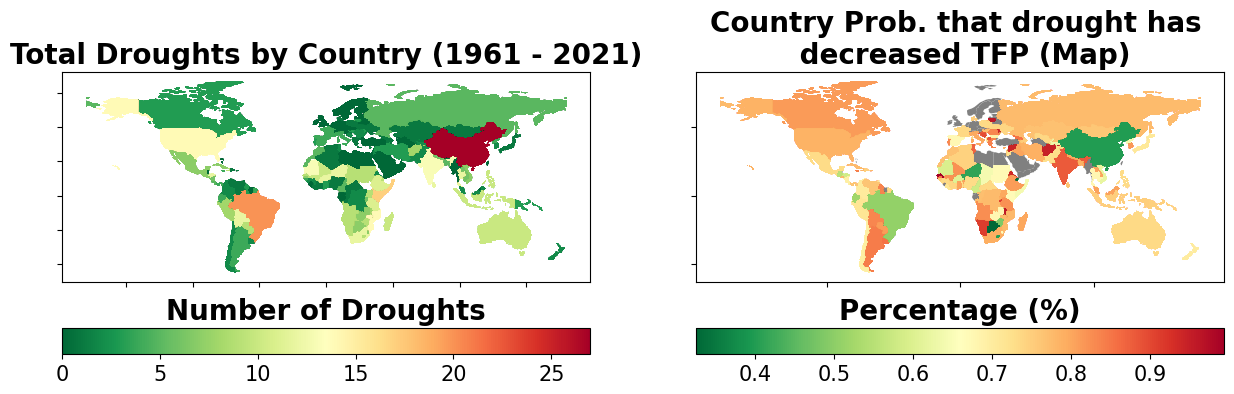

In [4]:
res = az.summary(trace, var_names=["country_rs_coefs"])
country_percentiles = {}
for index, country in enumerate(list(var_list[-163:])):
    country_percentiles[country.split("_")[0]] = len([sample for sample in unscaled_vars[country] if sample < 0])/len(unscaled_vars[country])
tfp_regression_data["drought_bin"] = list(map(lambda x : country_percentiles[x], tfp_regression_data.country))

# % chance region negatively affected

fig, axes = plt.subplots(1,2,figsize=(15,15))

# total droughts by country
droughts_by_country = {}
for country in set(tfp_regression_data.country):
    droughts_by_country[country] = np.count_nonzero(tfp_regression_data.loc[(tfp_regression_data.country == country)].drought)
tfp_regression_data["total_drought_by_country"] = list(map(lambda x : droughts_by_country[x], tfp_regression_data.country))

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    tfp_regression_data,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="total_drought_by_country", cmap="RdYlGn_r", ax=axes[0], legend=True, legend_kwds={"location":"bottom", "pad":.04})
axes[0].set_title("Total Droughts by Country (1961 - 2021)", size=20, weight="bold")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[0].set_xlabel("Number of Droughts", size=20, weight="bold")
axes[0].figure.axes[1].tick_params(labelsize=50)
res.figure.axes[-1].tick_params(labelsize=15)

countries_with_no_drought = []
for country in set(tfp_regression_data.country):
    if all(tfp_regression_data[tfp_regression_data.country == country].drought == 0):
        countries_with_no_drought.append(country)

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
tfp_regression_data_ndcr = tfp_regression_data[~tfp_regression_data.country.isin(countries_with_no_drought)]
country_geopandas[country_geopandas.iso_a3.isin(countries_with_no_drought)].plot(color='gray', ax=axes[1])
country_geopandas = country_geopandas.merge(
    tfp_regression_data_ndcr,
    how='inner',
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="drought_bin", cmap="RdYlGn_r", ax=axes[1], legend=True, legend_kwds={"location":"bottom", "pad":.04})

cmap = plt.get_cmap('RdYlGn_r')
norm = mcolors.Normalize(vmin=country_geopandas['drought_bin'].min(), vmax=country_geopandas['drought_bin'].max())
colors = [cmap(norm(value)) for value in country_geopandas['drought_bin']]
axes[1].set_title("Country Prob. that drought has \n decreased TFP (Map)", size=20, weight="bold")
axes[1].set_xlabel("Percentage (%)", size=20, weight="bold")
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
res.figure.axes[-1].tick_params(labelsize=15)

plt.savefig("../figures/drought_fig3.png", bbox_inches='tight')

In [33]:
print(np.mean(tfp_regression_data["drought_bin"]))
print(np.std(tfp_regression_data["drought_bin"]))

0.7430231124561963
0.10405663567530662


# Make map with percentage lost by country

/tmp/ipykernel_13709/1675697109.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_13709/1675697109.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')
/tmp/ipykernel_13709/1675697109.py:32: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_13709/1675697109.py:62: MatplotlibDeprecationWarning: The get_cmap functio

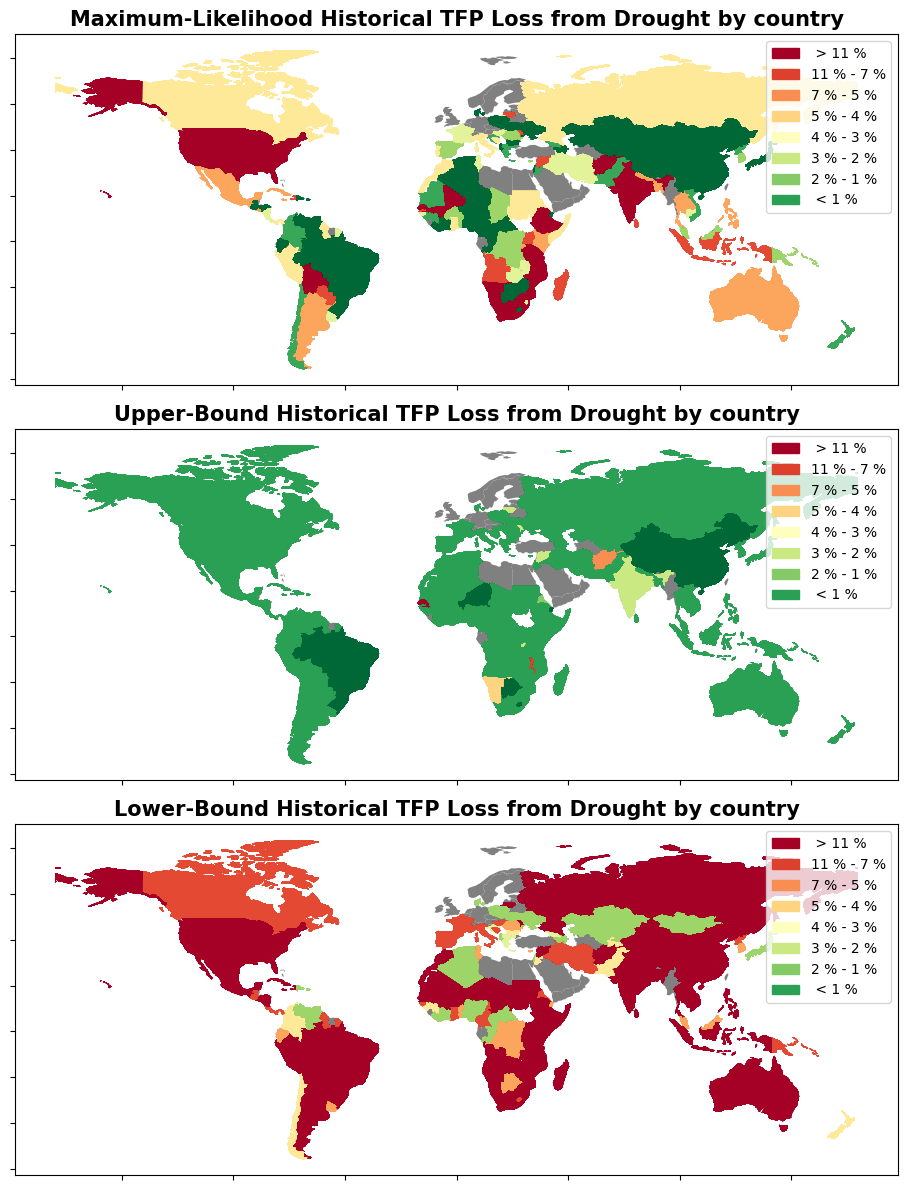

In [5]:
# % production deficit from drought
effect_by_country = {}
for country in set(tfp_regression_data.country):
    effect_by_country[country] = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
    for i in range(droughts_by_country[country]):
        effect_by_country[country] += unscaled_vars[country+"_country_fixed_effect"]

percent_loss_by_country = {
    country:np.array([math.expm1(val)*100 for val in effect_by_country[country]])
    for country in set(tfp_regression_data.country)
}

fig, axis = plt.subplots(3,1, figsize=(12,12))

axes = [axis[0], axis[1], axis[2]]
thresholds = [None, .84, .16]
threshold_labels = ["Maximum-Likelihood", "Upper-Bound", "Lower-Bound"]

for threshold, label, axis in zip(thresholds, threshold_labels, axes):
    country_percent_loss = {}
    for country, samples in percent_loss_by_country.items():
        sorted_samples = sorted(samples)
        if threshold != None:
            country_percent_loss[country] = np.quantile(sorted_samples, threshold)
        else:
            country_percent_loss[country] = np.mean(sorted_samples)
    
    tfp_regression_data[f"country_percent_loss_{label}"] = list(map(lambda x : country_percent_loss[x], tfp_regression_data.country))
    tfp_regression_data_ndcr = tfp_regression_data[~tfp_regression_data.country.isin(countries_with_no_drought)]
    
    country_geopandas = geopandas.read_file(
        geopandas.datasets.get_path('naturalearth_lowres')
    )
    country_geopandas[country_geopandas.iso_a3.isin(countries_with_no_drought)].plot(color='gray', ax=axis)
    country_geopandas = country_geopandas.merge(
        tfp_regression_data_ndcr,
        how='inner',
        left_on=['iso_a3'],
        right_on=['country']
    )
    bins = list(mapclassify.Quantiles(country_geopandas[f"country_percent_loss_Maximum-Likelihood"], k=10).bins)
    # delete bins that have similar range for map readability
    bins_to_remove = []
    for index, bin in enumerate(bins):
        if index != 0:
            if round(bin) == round(bins[index-1]):
                bins_to_remove.append(index)
    bins = [val for index, val in enumerate(bins) if index not in bins_to_remove]
    legend_labels = []
    bins_as_int = [-1*round(bin) for bin in bins]
    for index, bin in enumerate(bins_as_int):
        if index == 0:
            legend_labels.append(f" > {bin} %")
        elif index == len(bins_as_int) - 1:
            legend_labels.append(f" < {bins_as_int[index-1]} %")
            break
        else:
            legend_labels.append(f"{bins_as_int[index-1]} % - {bin} %")
    
    country_geopandas.plot(column=f"country_percent_loss_{label}", cmap='RdYlGn', scheme="User_Defined", classification_kwds=dict(bins=bins), ax=axis)
    
    cmap = cm.get_cmap('RdYlGn')
    legend_bins = []
    for index, legend_label in enumerate(legend_labels):
        legend_bins.append(mpatches.Patch(color=cmap((1/len(legend_labels)*index)), label=legend_label))
    axis.legend(handles=legend_bins)
    
    axis.set_title(f"{label} Historical TFP Loss from Drought by country", size=15, weight="bold")
    axis.set_yticklabels([])
    axis.set_xticklabels([])

plt.tight_layout()
plt.savefig("../figures/drought_fig4.png", bbox_inches='tight')

# Global Results

In [6]:
revenue_data = pd.read_csv("../data/revenue_shares.csv")
country_weights = {}
for row in revenue_data.itertuples():
    if row[3] in set(tfp_regression_data.country):
        country_weights[row[3]] = np.mean([row[5],row[6],row[7],row[8],row[9],row[10]])
weight_sum = sum(list(country_weights.values()))
for country, val in country_weights.items():
    country_weights[country] = val/weight_sum

Prob. of global TFP decrease from drought 0.7319
-3.787571307804744
-10.293202952832237 2.724158558559655


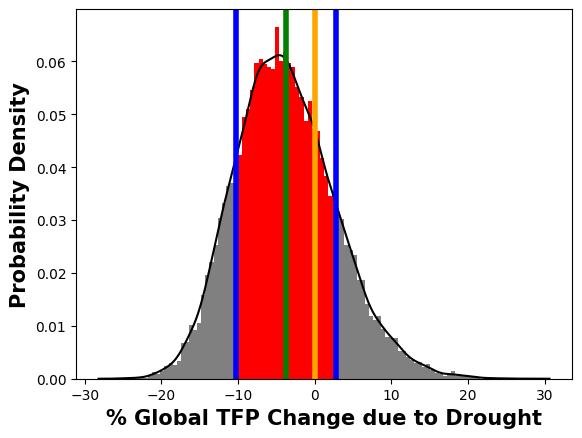

In [23]:
global_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
for country in set(tfp_regression_data.country):
    country_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
    for i in range(droughts_by_country[country]):
        country_effect += unscaled_vars[country+"_country_fixed_effect"] * country_weights[country]
    global_effect += country_effect

global_effect_percent = [math.expm1(val)*100 for val in global_effect]

print("Prob. of global TFP decrease from drought", len([val for val in global_effect_percent if val < 0])/20000)
print(np.mean(global_effect_percent))

q1 = np.quantile(global_effect_percent, .16)
q2 = np.quantile(global_effect_percent, .84)
print(q1, q2)
fig, ax = plt.subplots()
_, bins, patches = ax.hist(global_effect_percent, bins=100, density=True)
sns.kdeplot(global_effect_percent, ax=ax, color="black")
ax.axvline(q1, color = "blue", linewidth=4)
ax.axvline(q2, color = "blue", linewidth=4)
ax.axvline(0, color = "orange", linewidth=4)
ax.axvline(np.mean(global_effect_percent), color = "green", linewidth=4)
for index, bin in enumerate(bins):
    if index != len(bins)-1:
        if bin < q1 or bin > q2:
            patches[index].set_facecolor("gray")
        else:
            patches[index].set_facecolor("red")

plt.xlabel("% Global TFP Change due to Drought", size=15, weight="bold")
plt.ylabel("Probability Density", size=15, weight="bold")
plt.savefig("../figures/drought_fig5.png", bbox_inches='tight')

# Developed vs. Developing countries

/tmp/ipykernel_13709/2803639310.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfp_regression_data_["development"] = development_classification
/tmp/ipykernel_13709/2803639310.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfp_regression_data_["development_percent_loss"] = list(map(lambda x : development_percent_loss[x], tfp_regression_data_.development))
/tmp/ipykernel_13709/2803639310.py:39: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can

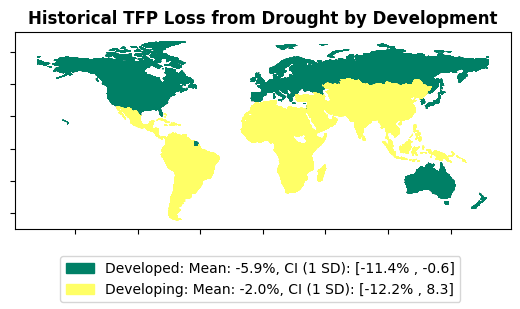

In [18]:
country_development_classification = pd.read_csv("../data/developed_developing_countries_UN.csv")
country_development_classification = {row[1]["ISO-alpha3 Code"]:row[1]["Developed / Developing regions"] for row in country_development_classification.iterrows()}

tfp_regression_data_ = tfp_regression_data[~tfp_regression_data.country.isin(["TWN"])]

development_classification = []
for row in tfp_regression_data_.iterrows():
    row = row[1]
    development_classification.append(country_development_classification[row.country])
tfp_regression_data_["development"] = development_classification

development_effect_percent = {}
for development in ["Developing","Developed"]:
    countries = [country for country in set(tfp_regression_data_.country) if country_development_classification[country] == development]
    sum_of_group_weights = 0
    for country in countries:
        sum_of_group_weights += country_weights[country]
    group_country_weights = {country:country_weights[country]/sum_of_group_weights for country in countries}
    development_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
    for country in countries:
        country_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
        for i in range(droughts_by_country[country]):
            country_effect += unscaled_vars[country+"_country_fixed_effect"] * group_country_weights[country]
        development_effect += country_effect
    development_effect_percent[development] = [math.expm1(val)*100 for val in development_effect]

fig, axis = plt.subplots()

development_percent_loss = {}
dpl_q1 = {}
dpl_q2 = {}
for development, samples in development_effect_percent.items():
    development_percent_loss[development] = np.mean(samples)
    dpl_q1[development] = np.quantile(samples, .16)
    dpl_q2[development] = np.quantile(samples, .84)
tfp_regression_data_["development_percent_loss"] = list(map(lambda x : development_percent_loss[x], tfp_regression_data_.development))

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    tfp_regression_data_,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)

country_geopandas.plot(column="development_percent_loss", cmap='summer', ax=axis)

legend_labels = [f"{development}: Mean: {round(development_percent_loss[development], 1)}%, CI (1 SD): [{round(dpl_q1[development], 1)}% , {round(dpl_q2[development], 1)}]" for development in ["Developed","Developing"]]
color_labels = [0,1000]
legend_bins = []
cmap = cm.get_cmap('summer')
for color, legend_label in zip(color_labels, legend_labels):
    legend_bins.append(mpatches.Patch(color=cmap(color), label=legend_label))
fig.legend(handles=legend_bins, loc="outside lower center")

axis.set_title(f"Historical TFP Loss from Drought by Development", size=12, weight="bold")
axis.set_yticklabels([])
axis.set_xticklabels([])

fig.subplots_adjust(bottom=-.15)

plt.savefig("../figures/drought_fig6.png", bbox_inches='tight')

# Regional Percentage Loss

In [81]:
tfp_regression_data.loc[tfp_regression_data.region23 == "Eastern Asia"]["region_percent_loss_Lower-Bound"]

1610   -18.457201
1611   -18.457201
1612   -18.457201
1613   -18.457201
1614   -18.457201
          ...    
8692   -18.457201
8693   -18.457201
8694   -18.457201
8695   -18.457201
8696   -18.457201
Name: region_percent_loss_Lower-Bound, Length: 360, dtype: float64

Melanesia
0.7541
Northern Europe
0.95695
Western Africa
0.9399
Eastern Asia
0.40105
Eastern Africa
0.9581
Australia and New Zealand
0.75055
Central Asia
0.8454
South America
0.5739
Eastern Europe
0.84215
Southern Africa
0.80125
Middle Africa
0.8372
South-Eastern Asia
0.83235
Northern America
0.7923
Southern Asia
0.89935
Southern Europe
0.8411
Western Europe
0.7364
Western Asia
0.97945
Northern Africa
0.8014
Central America
0.7609
Caribbean
0.85815


/tmp/ipykernel_13709/3358143793.py:36: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_13709/3358143793.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')
/tmp/ipykernel_13709/3358143793.py:36: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_13709/3358143793.py:65: MatplotlibDeprecationWarning: The get_cmap functio

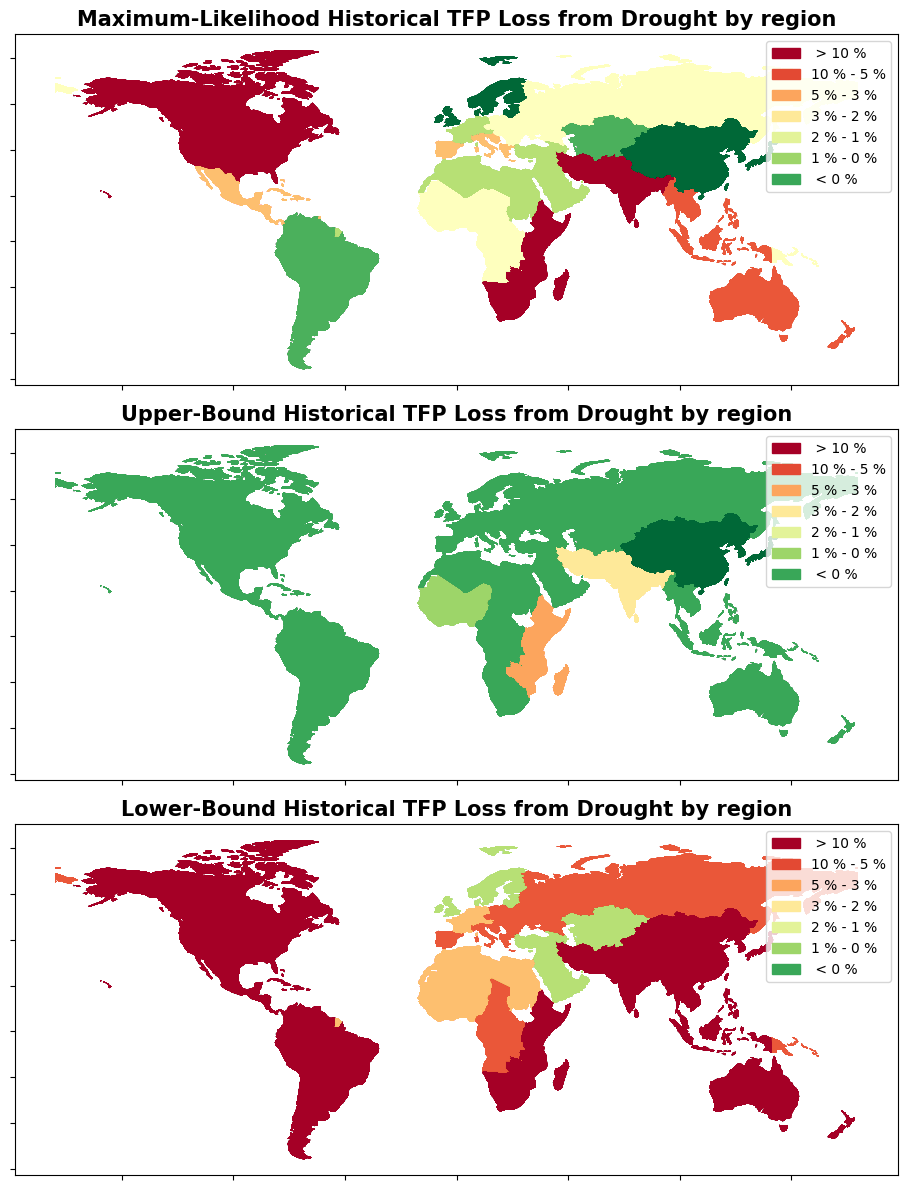

In [25]:
percent_loss_by_region = {}
for region in set(tfp_regression_data.region23):
    countries = set(tfp_regression_data.loc[tfp_regression_data.region23 == region].country)
    sum_of_group_weights = 0
    for country in countries:
        sum_of_group_weights += country_weights[country]
    group_country_weights = {country:country_weights[country]/sum_of_group_weights for country in countries}
    region_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
    for country in countries:
        country_effect = [0]*len(unscaled_vars["AFG_country_fixed_effect"])
        for i in range(droughts_by_country[country]):
            country_effect += unscaled_vars[country+"_country_fixed_effect"] * group_country_weights[country]
        if not all(country_effect) == 0:
            region_effect += country_effect
    percent_loss_by_region[region] = [math.expm1(val)*100 for val in region_effect]
    
fig, axis = plt.subplots(3,1, figsize=(12,12))

axes = [axis[0], axis[1], axis[2]]
thresholds = [None, .84, .16]
threshold_labels = ["Maximum-Likelihood", "Upper-Bound", "Lower-Bound"]

for threshold, label, axis in zip(thresholds, threshold_labels, axes):
    region_percent_loss = {}
    for region, samples in percent_loss_by_region.items():
        if threshold != None:
            region_percent_loss[region] = np.quantile(samples, threshold)
        else:
            region_percent_loss[region] = np.mean(samples)
    
    tfp_regression_data[f"region_percent_loss_{label}"] = list(map(lambda x : region_percent_loss[x], tfp_regression_data.region23))
    
    region_geopandas = geopandas.read_file(
        geopandas.datasets.get_path('naturalearth_lowres')
    )
    region_geopandas = region_geopandas.merge(
        tfp_regression_data,
        how='inner',
        left_on=['iso_a3'],
        right_on=['country']
    )
    bins = list(mapclassify.Quantiles(region_geopandas[f'region_percent_loss_Maximum-Likelihood'], k=10).bins)
    # delete bins that have similar range for map readability
    bins_to_remove = []
    for index, bin in enumerate(bins):
        if index != 0:
            if int(str(bin).split(".")[0]) == int(str(bins[index-1]).split(".")[0]):
                bins_to_remove.append(index)
    bins = [val for index, val in enumerate(bins) if index not in bins_to_remove]
    legend_labels = []
    bins_as_int = [-1*int(str(bin).split(".")[0]) for bin in bins]
    for index, bin in enumerate(bins_as_int):
        if index == 0:
            legend_labels.append(f" > {bin} %")
        elif index == len(bins_as_int) - 1:
            legend_labels.append(f" < {bins_as_int[index-1]} %")
            break
        else:
            legend_labels.append(f"{bins_as_int[index-1]} % - {bin} %")
    region_geopandas.plot(column=f'region_percent_loss_{label}', cmap='RdYlGn', scheme="User_Defined", 
             legend=True, classification_kwds=dict(bins=bins), ax=axis)

    cmap = cm.get_cmap('RdYlGn')
    legend_bins = []
    for index, legend_label in enumerate(legend_labels):
        legend_bins.append(mpatches.Patch(color=cmap((1/len(legend_labels)*index)), label=legend_label))
    axis.legend(handles=legend_bins)
    
    axis.set_title(f"{label} Historical TFP Loss from Drought by region", size=15, weight="bold")
    axis.set_yticklabels([])
    axis.set_xticklabels([])

plt.tight_layout()
plt.savefig("../figures/drought_fig2.png", bbox_inches='tight')

# Regional probability of loss

In [54]:
region_percentiles

{'Melanesia': 0.7541,
 'Northern Europe': 0.95695,
 'Western Africa': 0.9399,
 'Eastern Asia': 0.40105,
 'Eastern Africa': 0.9581,
 'Australia and New Zealand': 0.75055,
 'Central Asia': 0.8454,
 'South America': 0.5739,
 'Eastern Europe': 0.84215,
 'Southern Africa': 0.80125,
 'Middle Africa': 0.8372,
 'South-Eastern Asia': 0.83235,
 'Northern America': 0.7923,
 'Southern Asia': 0.89935,
 'Southern Europe': 0.8411,
 'Western Europe': 0.7364,
 'Western Asia': 0.97945,
 'Northern Africa': 0.8014,
 'Central America': 0.7609,
 'Caribbean': 0.85815}

/tmp/ipykernel_13709/1021980773.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')
/tmp/ipykernel_13709/1021980773.py:33: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  geopandas.datasets.get_path('naturalearth_lowres')


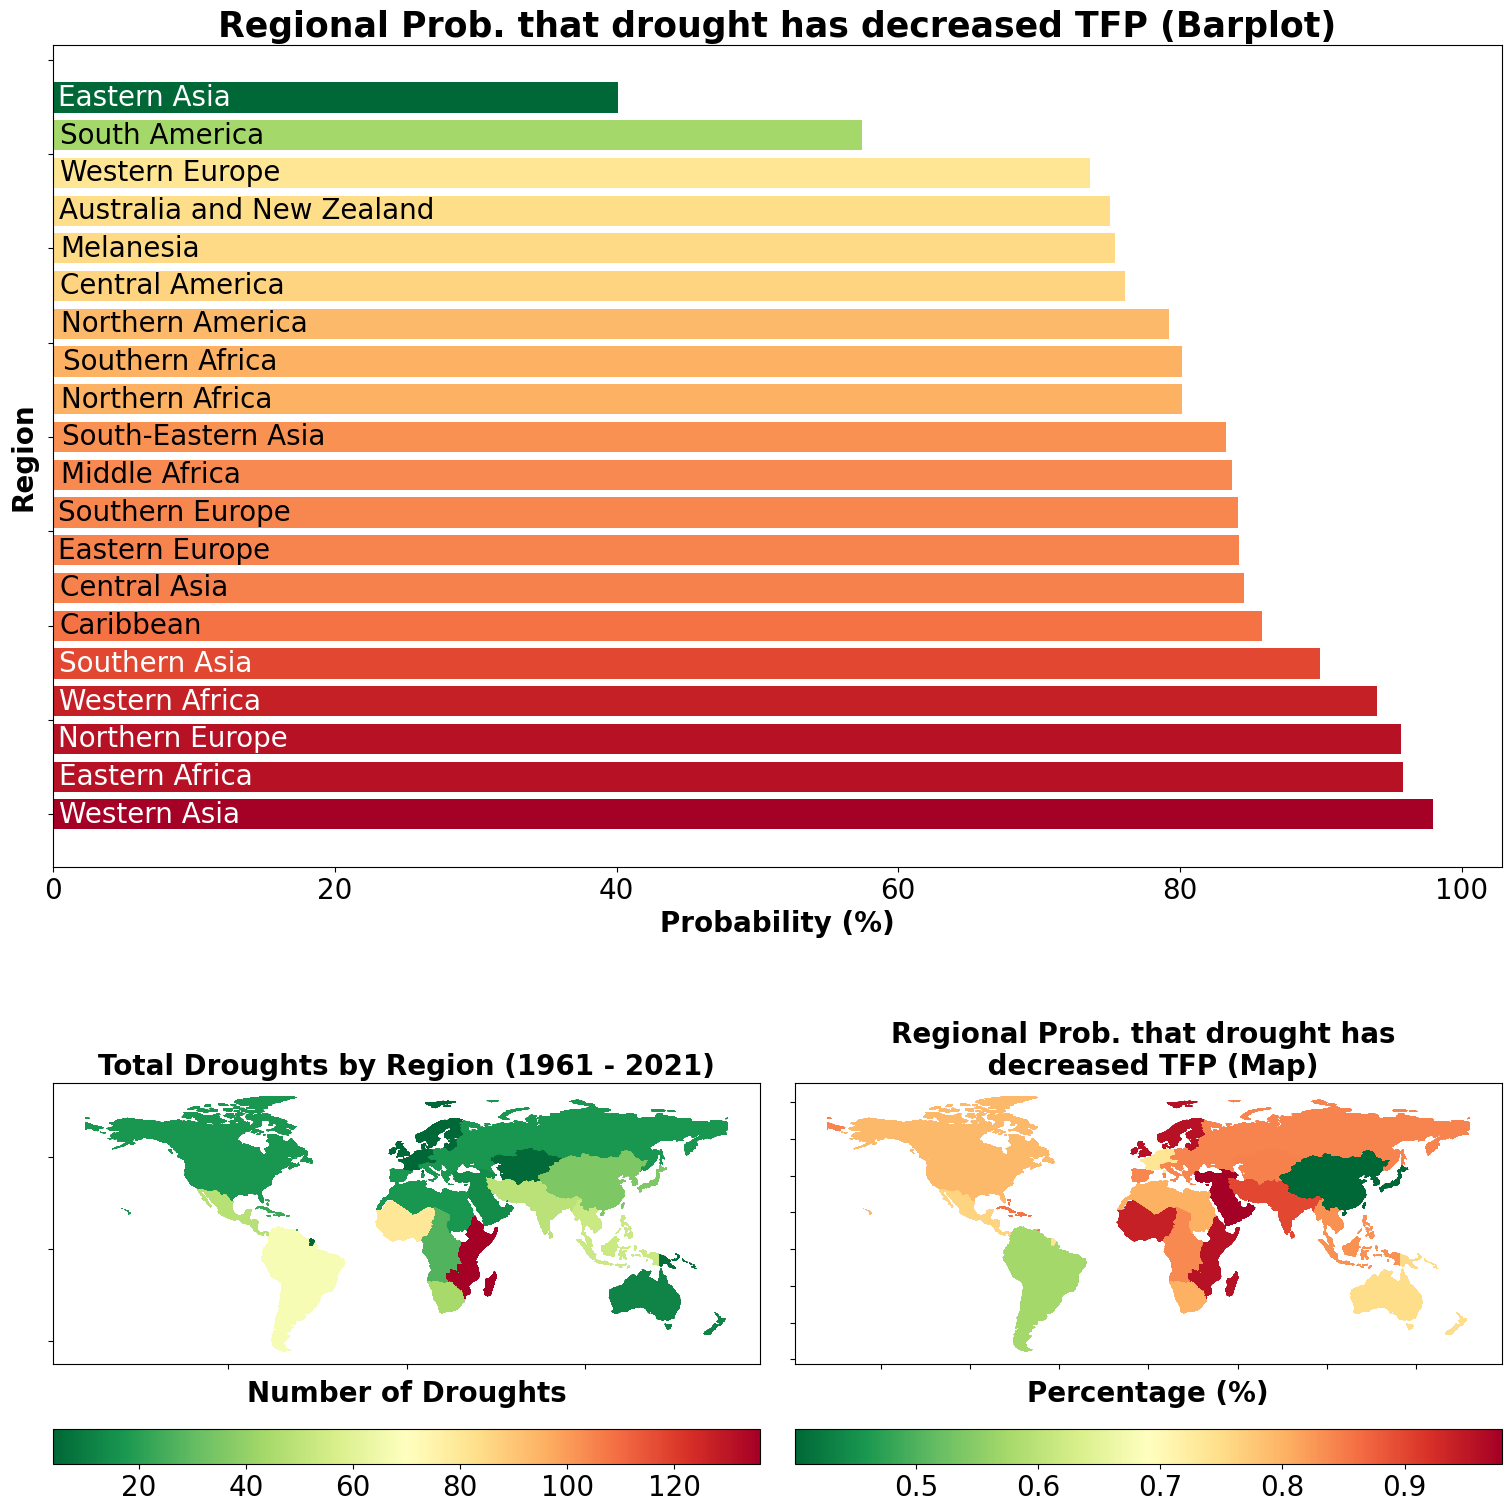

In [82]:
region_percentiles = {}
for region in set(tfp_regression_data.region23):
    region_percentiles[region] = len([val for val in percent_loss_by_region[region] if val < 0])/20000

tfp_regression_data["drought_bin"] = list(map(lambda x : region_percentiles[x], tfp_regression_data.region23))

fig = plt.figure(constrained_layout=True, figsize=(15,15))
axs = fig.subplot_mosaic([['Top', 'Top'],['BottomLeft', 'BottomRight']], gridspec_kw={'width_ratios':[1,1], 'height_ratios':[1,.5]})

droughts_by_region = {}
for region in set(tfp_regression_data.region23):
    droughts_by_region[region] = np.count_nonzero(tfp_regression_data.loc[(tfp_regression_data.region23 == region)].drought)
tfp_regression_data["total_drought_by_region"] = list(map(lambda x : droughts_by_region[x], tfp_regression_data.region23))

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    tfp_regression_data,
    how='inner', 
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="total_drought_by_region", cmap="RdYlGn_r", ax=axs["BottomLeft"], legend=True, legend_kwds={"location":"bottom"})
axs["BottomLeft"].set_title("Total Droughts by Region (1961 - 2021)", size=20, weight="bold")
axs["BottomLeft"].set_xticklabels([])
axs["BottomLeft"].set_yticklabels([])
axs["BottomLeft"].set_xlabel("Number of Droughts", size=20, weight="bold")
axs["BottomLeft"].figure.axes[1].tick_params(labelsize=50)
res.figure.axes[-1].tick_params(labelsize=20)

country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
country_geopandas = country_geopandas.merge(
    tfp_regression_data,
    how='inner',
    left_on=['iso_a3'],
    right_on=['country']
)
res = country_geopandas.plot(column="drought_bin", cmap="RdYlGn_r", ax=axs["BottomRight"], legend=True, legend_kwds={"location":"bottom"})
cmap = plt.get_cmap('RdYlGn_r')
norm = mcolors.Normalize(vmin=country_geopandas['drought_bin'].min(), vmax=country_geopandas['drought_bin'].max())
colors = [cmap(norm(value)) for value in country_geopandas['drought_bin']]
axs["BottomRight"].set_title("Regional Prob. that drought has \n decreased TFP (Map)", size=20, weight="bold")
axs["BottomRight"].set_xlabel("Percentage (%)", size=20, weight="bold")
axs["BottomRight"].set_xticklabels([])
axs["BottomRight"].set_yticklabels([])
res.figure.axes[-1].tick_params(labelsize=20)

sorted_region_percentiles = dict(sorted(region_percentiles.items(), key=lambda x: x[1], reverse=True))
region_colors = []
for region in sorted_region_percentiles.keys():
    region_index = country_geopandas.loc[country_geopandas.region23 == region].index[0]
    region_colors.append(colors[region_index])

barcounts = [val*100 for val in list(sorted_region_percentiles.values())]
barplot = axs["Top"].barh(list(range(0,20)), barcounts, color=region_colors)
barcolors = ["white","white","white","white","white","black","black","black","black","black","black","black","black","black","black","black","black","black","black","white"]
barlabels = axs["Top"].bar_label(barplot, list(sorted_region_percentiles.keys()), label_type = "center")
barpaddings = list(reversed([62,-13,-89,-41,-127,-100,-107,-122,-125,-121,-154,-139,-147,-163,-179,-182,-200,-199,-212,-227]))
for index, bar_label in enumerate(barlabels):
    bar_label.set_x(bar_label.get_position()[1] - 200 + barpaddings[index])
for i, text in enumerate(axs["Top"].texts):
    text.set_color(barcolors[i])
    text.set_size(20)
axs["Top"].set_title("Regional Prob. that drought has decreased TFP (Barplot)", size=25, weight="bold")
axs["Top"].set_xlabel("Probability (%)", weight="bold", size=20)
axs["Top"].set_ylabel("Region", weight="bold", size=20)
axs["Top"].set_yticklabels([])
axs["Top"].xaxis.set_tick_params(labelsize=20)

plt.savefig("../figures/drought_fig1.png", bbox_inches='tight')